In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.6.0


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

In [7]:
import time

In [4]:
main_data=pd.read_csv("sarcasm_v2\\GEN-sarc-notsarc.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
data["class"] = data["class"].map(classes)
data

,class,text
0,0,"If that's true, then Freedom of Speech is doom..."
1,0,Neener neener - is it time to go in from the p...
2,0,"Just like the plastic gun fear, the armour pie..."
3,0,So geology is a religion because we weren't he...
4,0,Well done Monty. Mark that up as your first ev...
...,...,...
6515,1,depends on when the baby bird died. run alon...
6516,1,"ok, sheesh, to clarify, women who arent aborti..."
6517,1,so.. eh?? hows this sound? will it fly w...
6518,1,"I think we should put to a vote, the right of ..."


In [5]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#batch_1 = data.sample(n = 500)

In [25]:
f=open('features.csv','ab')
for i in range(500,data.shape[0],500):
    print("Processing Batch: ",i-500,",",i)
    start_time = time.time()
    batch_1=data[i-500:i]
    tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    np.array(padded).shape
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()
    np.savetxt(f,features, delimiter=',')
    print("Batch Complete.\nTime Taken: %.2f minutes\n" % ((time.time() - start_time)/60))
    time.sleep(5)
f.close()

Processing Batch:  0 , 500
Batch Complete.
Time Taken: 18.03 minutes

Processing Batch:  500 , 1000
Batch Complete.
Time Taken: 14.56 minutes

Processing Batch:  1000 , 1500
Batch Complete.
Time Taken: 8.39 minutes

Processing Batch:  1500 , 2000
Batch Complete.
Time Taken: 5.54 minutes

Processing Batch:  2000 , 2500
Batch Complete.
Time Taken: 9.17 minutes

Processing Batch:  2500 , 3000
Batch Complete.
Time Taken: 7.40 minutes

Processing Batch:  3000 , 3500
Batch Complete.
Time Taken: 6.78 minutes

Processing Batch:  3500 , 4000
Batch Complete.
Time Taken: 6.36 minutes

Processing Batch:  4000 , 4500
Batch Complete.
Time Taken: 6.07 minutes

Processing Batch:  4500 , 5000
Batch Complete.
Time Taken: 6.29 minutes

Processing Batch:  5000 , 5500
Batch Complete.
Time Taken: 8.26 minutes

Processing Batch:  5500 , 6000
Batch Complete.
Time Taken: 7.97 minutes

Processing Batch:  6000 , 6500
Batch Complete.
Time Taken: 5.67 minutes



In [29]:
features=pd.read_csv("features.csv",header=None)

In [32]:
features=features.to_numpy()

In [33]:
labels = data['class'][:6500]

In [46]:
#Plotting confusion matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [34]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [40]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
y_pred_lr = lr_clf.predict(test_features)
lr_clf.score(test_features, test_labels)

C:\Users\Taha\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7747692307692308

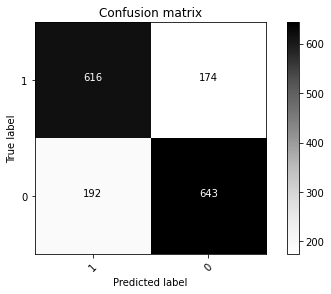

In [49]:
c = confusion_matrix(test_labels,y_pred_lr)
plot_confusion_matrix(c,["1","0"])

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

dt_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_clf = dt_clf.fit(train_features, train_labels)

#Predict the response for test dataset
y_pred_dt = dt_clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(y_pred_dt, test_labels))

Accuracy: 0.6492307692307693


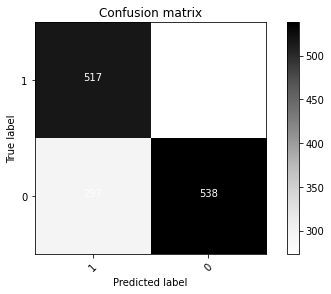

In [56]:
c = confusion_matrix(test_labels,y_pred_dt)
plot_confusion_matrix(c,["1","0"])

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(train_features, train_labels)

#Predict the response for test dataset
y_pred_rf = rf_clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(y_pred_rf, test_labels))

C:\Users\Taha\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.7132307692307692


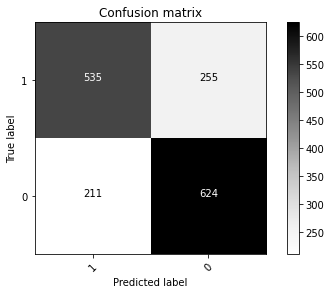

In [58]:
c = confusion_matrix(test_labels,y_pred_rf)
plot_confusion_matrix(c,["1","0"])